# Imports

In [1]:
import io
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd 
import seaborn as sns

from google.colab import files
from google.colab import drive

from sklearn.preprocessing import LabelEncoder

# The Data

In [2]:
uploaded = files.upload()

Saving team6.json to team6.json


In [3]:
df = pd.read_json(io.BytesIO(uploaded['team6.json']), lines=True)

df.head()

,_id,worldTime,player,experimentLabel,time,event,material,totalSize,totalSpaceSize,content,distances,zone,isSneaking,x,isSprinting,y,z,pitch,yaw,newSlot,damage,health,cause,entityID,entity,blockFace,action,blockX,blockY,blockZ,lookingAt,msg,slotType,currentAmount,cursorItem,slot,cursorAmount,currentItem,foodLevel,delta,worldUUID,special,itemID,item,amount,tags,puzzle,droppedBy,ore,trophy,tradedFor,projectileType,projectile,isFlying,cmd
0,{'$oid': '617086ee4d618a287fc62c05'},23027.0,ffaa5663-850e-4009-80c4-c8bbe34cd285,group1,1634764523240,PlayerLoginEvent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,{'$oid': '617086ef4d618a287fc62c06'},23028.0,ffaa5663-850e-4009-80c4-c8bbe34cd285,group1,1634764523287,PlayerJoinEvent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,{'$oid': '617086ef4d618a287fc62c07'},23028.0,ffaa5663-850e-4009-80c4-c8bbe34cd285,group1,1634764523292,PlayerGameModeChangeEvent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,{'$oid': '617086ef4d618a287fc62c08'},NaN,ffaa5663-850e-4009-80c4-c8bbe34cd285,group1,1634764523287,PlayerItemInHandEvent,AIR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,{'$oid': '617086ef4d618a287fc62c09'},NaN,ffaa5663-850e-4009-80c4-c8bbe34cd285,group1,1634764523287,InventoryContent,NaN,0.0,0.0,{},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Drop some useless events

In [4]:
# Bad Columns
df = df.drop(['_id','worldUUID','isFlying','cmd','foodLevel'], axis=1)

# Useless Events 
df.drop(df[df['event'] == 'PlayerBedEnterEvent'].index, inplace=True)
df.drop(df[df['event'] == 'PlayerBedLeaveEvent'].index, inplace=True)
df.drop(df[df['event'] == 'PlayerEggThrowEvent'].index, inplace=True)
df.drop(df[df['event'] == 'PlayerKickEvent'].index, inplace=True)
df.drop(df[df['event'] == 'CraftItemEvent'].index, inplace=True)
df.drop(df[df['event'] == 'EnderChestContent'].index, inplace=True)
df.drop(df[df['event'] == 'PlayerLoginEvent'].index, inplace=True)
df.drop(df[df['event'] == 'PlayerJoinEvent'].index, inplace=True)
df.drop(df[df['event'] == 'PlayerQuitEvent'].index, inplace=True)
df.drop(df[df['event'] == 'PlayerCommandPreprocessEvent'].index, inplace=True)
df.drop(df[df['event'] == 'PlayerGameModeChangeEvent'].index, inplace=True)
df.drop(df[df['event'] == 'PlayerVelocityEvent'].index, inplace=True)
df.drop(df[df['event'] == 'PlayerToggleSneakEvent '].index, inplace=True)
df.drop(df[df['event'] == 'InventoryOpenEvent'].index, inplace=True)
df.drop(df[df['event'] == 'InventoryDragEvent'].index, inplace=True)
df.drop(df[df['event'] == 'FoodLevelChangeEvent'].index, inplace=True)
df.drop(df[df['event'] == 'PlayerToggleSprintEvent'].index, inplace=True)

# Extra Players and mysterious events
df.drop(df[df['player'] == 'd122c4e7-dcbe-4af3-bbe8-4b9dc90eaa37'].index, inplace=True)
df.drop(df[df['player'] == 'a0b18a63-90be-4938-b363-6aa1d72ff1d4'].index, inplace=True)
df = df[df['player'].notna()]
df = df[df['experimentLabel'].notna()]

In [5]:
playerEncode = LabelEncoder()
df['player'] = df['player'].astype(str)
df['player'] = playerEncode.fit_transform(df['player'])
df.player.value_counts()

0    127540
1    106364
2     76993
3     71959
Name: player, dtype: int64

In [6]:
groupEncode = LabelEncoder()
df['experimentLabel'] = df['experimentLabel'].astype(str)
df['experimentLabel'] = playerEncode.fit_transform(df['experimentLabel'])
df.experimentLabel.value_counts()

3    79905
4    71280
5    69557
2    61965
1    53774
0    46375
Name: experimentLabel, dtype: int64

In [7]:
df.event.value_counts()

UsingSpecialItemEvent         118824
PlayerLocationEvent            90590
PlayerInteractEvent            44486
BlockDamageEvent               32646
BlockBreakEvent                29870
DuneBreakEvent                 26421
PlayerItemHeldEvent             4633
PlayerItemInHandEvent           4620
DoFarmEvent                     4454
InventoryContent                4296
PlayerPickupItemEvent           3166
BlockPlaceEvent                 2757
PlayerToggleSneakEvent          2430
PlayerDamageByPlayerEvent       2032
InventoryClickEvent             1990
EntityDamageByPlayerEvent       1752
AsyncPlayerChatEvent            1719
InventoryCloseEvent             1452
OreBreakEvent                   1110
ProjectileLaunchEvent            626
BarrelOpenedEvent                494
EntityShootBowEvent              457
PlayerDropItemEvent              425
PlayerDamageByEntityEvent        330
PlayerInteractEntityEvent        208
PlayerTeleportEvent              172
SolveMansionPuzzleEvent          167
P

In [8]:
# Event removing temp
df_filter = df[df['event'] == 'PlayerDamageByEntityEvent']
#df_filter = df[df['foodLevel'].notna()]
df_filter.entity.value_counts()
#df_filter.head(10)

SKELETON    180
ZOMBIE       84
CREEPER      34
SPIDER       32
Name: entity, dtype: int64

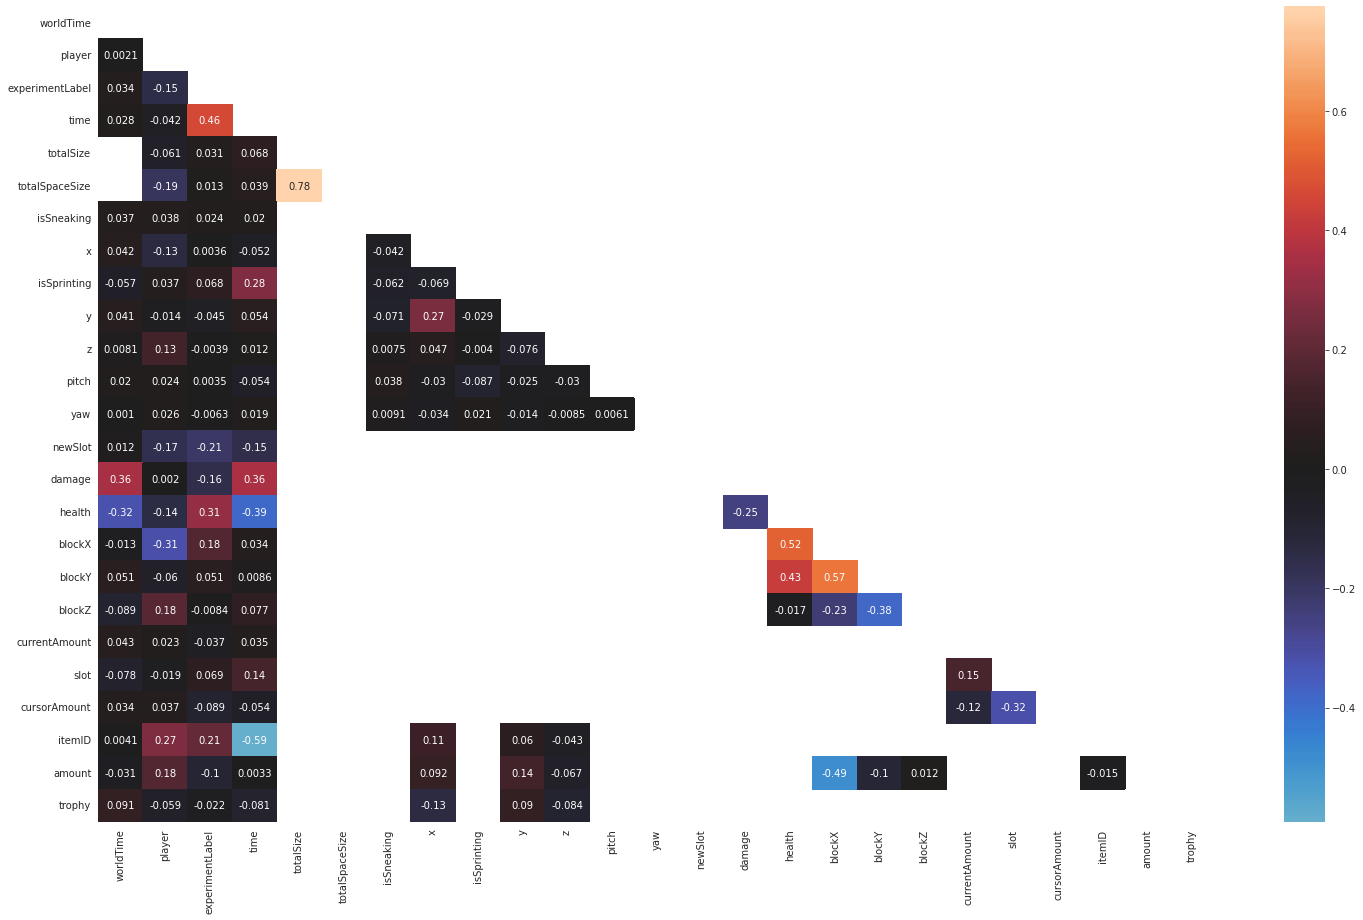

In [9]:
corrmatx = df.corr()
mask = np.zeros_like(corrmatx)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(25,15))
    ax = sns.heatmap(corrmatx, mask=mask, center=0, annot=True)

In [10]:
def add_event_data(event, colname, groupname, ndf, gdf, cdf, odf):
  temp_df = pd.DataFrame()
  groups = [i for i in range(6)]
  players = [0,1,2,3]
  col = []
  groupcol = []
  indexx=[i for i in range(24)]

  for group in groups:
    grouptotal = 0
    temp_df = odf[odf['experimentLabel']==group]
    temp_df = temp_df[temp_df['event']==event]
    for player in players:
      col.append(temp_df[temp_df['player']==player].shape[0])
      grouptotal += temp_df[temp_df['player']==player].shape[0]
    
    temptrp = [grouptotal] * 4
    groupcol.extend(temptrp)

  dftrp = pd.Series(col,index=indexx)
  groupdftrp = pd.Series(groupcol,index=indexx)
  ndf[colname] = dftrp
  cdf[colname] = dftrp
  gdf[groupname] = groupdftrp
  cdf[groupname] = groupdftrp
  

def add_pve_data(event, mobCol, groupMobCol, aniCol, groupAniCol, ndf, gdf, cdf, odf):
  temp_df = pd.DataFrame()
  groups = [i for i in range(6)]
  players = [0,1,2,3]
  mobs = ['ZOMBIE','CREEPER','SKELETON','SPIDER']
  animals = ['PIG','HORSE','SHEEP','CHICKEN','COW','BAT']
  anicol = []
  groupanicol = []
  mobcol = []
  groupmobcol = []
  indexx=[i for i in range(24)]

  for group in groups:
    anitotal = 0
    mobtotal = 0
    temp_df = odf[odf['experimentLabel']==group]
    temp_df = temp_df[temp_df['event']==event]
    ani_df = temp_df[temp_df['entity'].isin(animals)]
    mob_df = temp_df[temp_df['entity'].isin(mobs)]
    for player in players:
      anicol.append(ani_df[ani_df['player']==player].shape[0])
      anitotal += ani_df[ani_df['player']==player].shape[0]
      mobcol.append(mob_df[mob_df['player']==player].shape[0])
      mobtotal += mob_df[mob_df['player']==player].shape[0]
    
    temptrp = [mobtotal] * 4
    groupmobcol.extend(temptrp)
    temptrp = [anitotal] * 4
    groupanicol.extend(temptrp)

  dftrp = pd.Series(mobcol,index=indexx)
  groupdftrp = pd.Series(groupmobcol,index=indexx)
  ndf[mobCol] = dftrp
  cdf[mobCol] = dftrp
  gdf[groupMobCol] = groupdftrp
  cdf[groupMobCol] = groupdftrp

  dftrp = pd.Series(anicol,index=indexx)
  groupdftrp = pd.Series(groupanicol,index=indexx)
  ndf[aniCol] = dftrp
  cdf[aniCol] = dftrp
  gdf[groupAniCol] = groupdftrp
  cdf[groupAniCol] = groupdftrp

In [11]:
proto = {'player':[0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3], 'group':[0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5]}

newdf = pd.DataFrame(data=proto)
groupdf = pd.DataFrame(data=proto)
combdf = pd.DataFrame(data=proto)
temp_df = pd.DataFrame()
col = []
groupcol = []

add_event_data('AsyncPlayerChatEvent', 'messages', 'groupMessages', newdf, groupdf, combdf, df)
add_event_data('CrouchGreetingEvent', 'greeting', 'groupGreeting', newdf, groupdf, combdf, df)
add_event_data('PlayerDamageByPlayerEvent', 'pvp', 'groupPvp', newdf, groupdf, combdf, df)
add_event_data('SolveMansionPuzzleEvent', 'mansionPuzzles', 'groupMansionPuzzles', newdf, groupdf, combdf, df)
add_event_data('BarrelOpenedEvent', 'barrels', 'groupBarrels', newdf, groupdf, combdf, df)
add_event_data('DoFarmEvent', 'farm', 'groupFarm', newdf, groupdf, combdf, df)
add_event_data('OreBreakEvent', 'mine', 'groupMine', newdf, groupdf, combdf, df)
add_event_data('DuneBreakEvent', 'dune', 'groupDune', newdf, groupdf, combdf, df)
add_event_data('VillagerTradeEvent', 'villagers', 'groupVillagers', newdf, groupdf, combdf, df)
add_pve_data('EntityDamageByPlayerEvent', 'pveMobs', 'groupPveMobs', 'pveAnimals', 'groupPveAnimals', newdf, groupdf, combdf, df)
add_event_data('PlayerRespawnEvent', 'deaths', 'groupDeaths', newdf, groupdf, combdf, df)
add_event_data('CollectTrophyEvent', 'trophies', 'groupTrophies', newdf, groupdf, combdf, df)

In [12]:
newdf.head() 

,player,group,messages,greeting,pvp,mansionPuzzles,barrels,farm,mine,dune,villagers,pveMobs,pveAnimals,deaths,trophies
0,0,0,157,5,0,14,30,14,125,0,2,158,12,0,6
1,1,0,32,3,130,0,7,166,0,2247,0,4,0,0,0
2,2,0,80,23,0,1,11,269,0,373,2,54,6,0,8
3,3,0,55,8,2,8,19,164,79,0,4,8,22,0,2
4,0,1,81,0,66,3,16,21,0,0,0,40,22,3,4


In [13]:
groupdf.head()

,player,group,groupMessages,groupGreeting,groupPvp,groupMansionPuzzles,groupBarrels,groupFarm,groupMine,groupDune,groupVillagers,groupPveMobs,groupPveAnimals,groupDeaths,groupTrophies
0,0,0,324,39,132,23,67,613,204,2620,8,224,40,0,16
1,1,0,324,39,132,23,67,613,204,2620,8,224,40,0,16
2,2,0,324,39,132,23,67,613,204,2620,8,224,40,0,16
3,3,0,324,39,132,23,67,613,204,2620,8,224,40,0,16
4,0,1,286,20,128,25,71,976,206,1387,7,214,282,14,14


In [14]:
combdf.head()

,player,group,messages,groupMessages,greeting,groupGreeting,pvp,groupPvp,mansionPuzzles,groupMansionPuzzles,barrels,groupBarrels,farm,groupFarm,mine,groupMine,dune,groupDune,villagers,groupVillagers,pveMobs,groupPveMobs,pveAnimals,groupPveAnimals,deaths,groupDeaths,trophies,groupTrophies
0,0,0,157,324,5,39,0,132,14,23,30,67,14,613,125,204,0,2620,2,8,158,224,12,40,0,0,6,16
1,1,0,32,324,3,39,130,132,0,23,7,67,166,613,0,204,2247,2620,0,8,4,224,0,40,0,0,0,16
2,2,0,80,324,23,39,0,132,1,23,11,67,269,613,0,204,373,2620,2,8,54,224,6,40,0,0,8,16
3,3,0,55,324,8,39,2,132,8,23,19,67,164,613,79,204,0,2620,4,8,8,224,22,40,0,0,2,16
4,0,1,81,286,0,20,66,128,3,25,16,71,21,976,0,206,0,1387,0,7,40,214,22,282,3,14,4,14


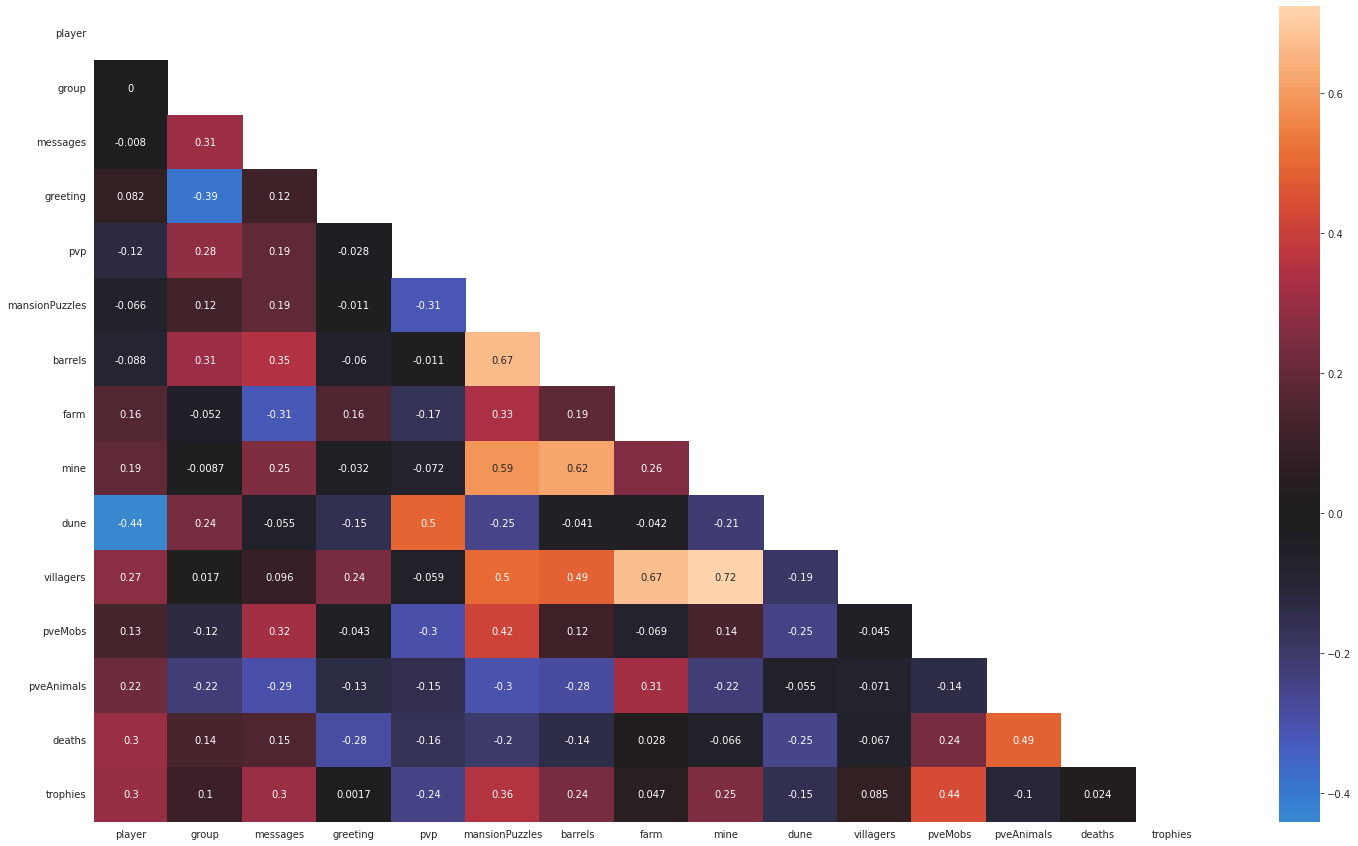

In [15]:
corrmatx = newdf.corr()
mask = np.zeros_like(corrmatx)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(25,15))
    ax = sns.heatmap(corrmatx, mask=mask, center=0, annot=True)

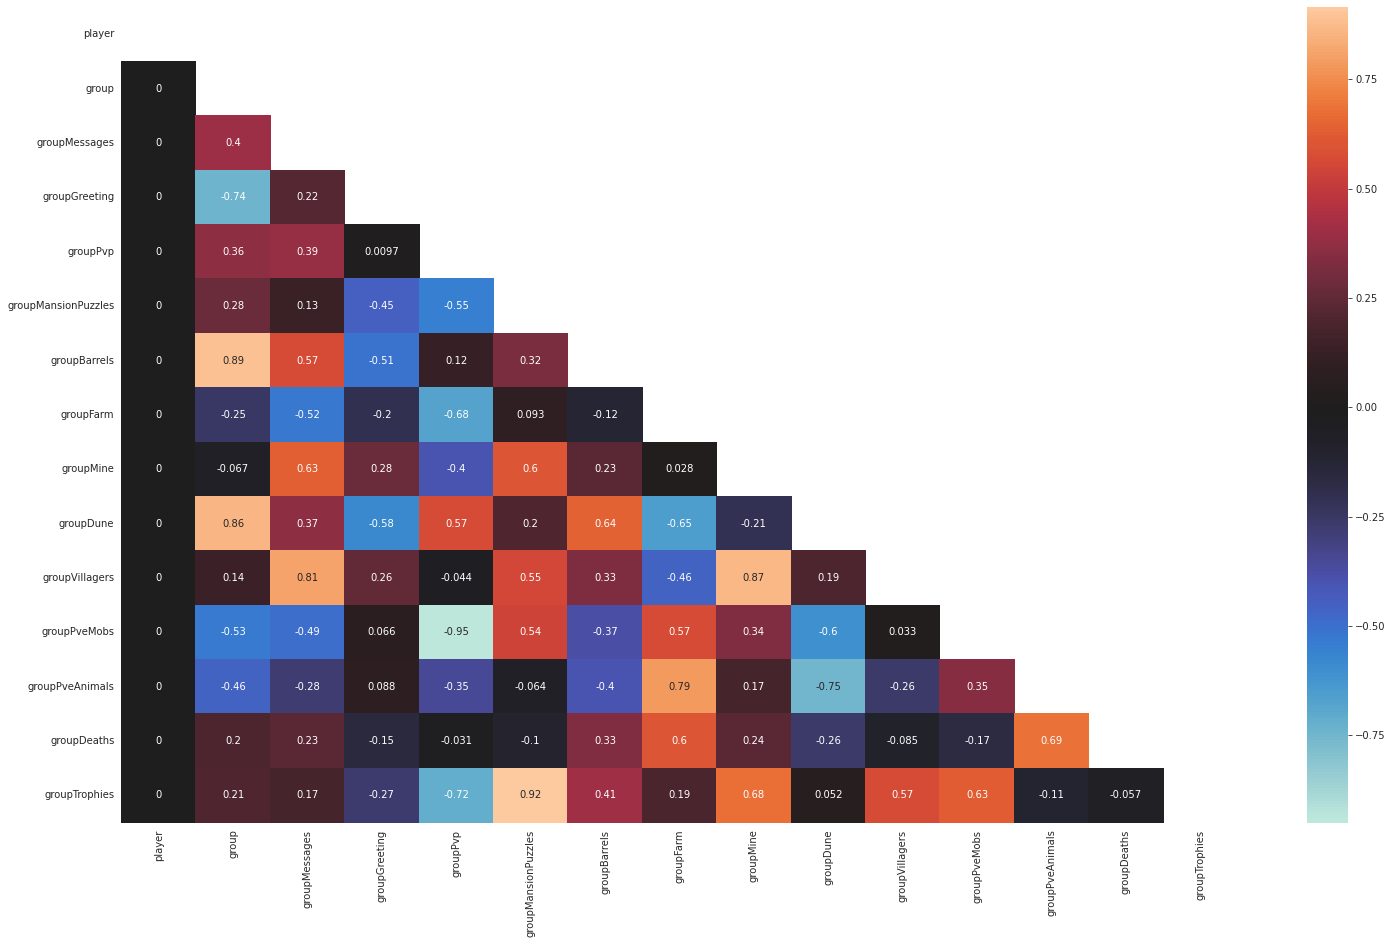

In [16]:
corrmatx = groupdf.corr()
mask = np.zeros_like(corrmatx)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(25,15))
    ax = sns.heatmap(corrmatx, mask=mask, center=0, annot=True)

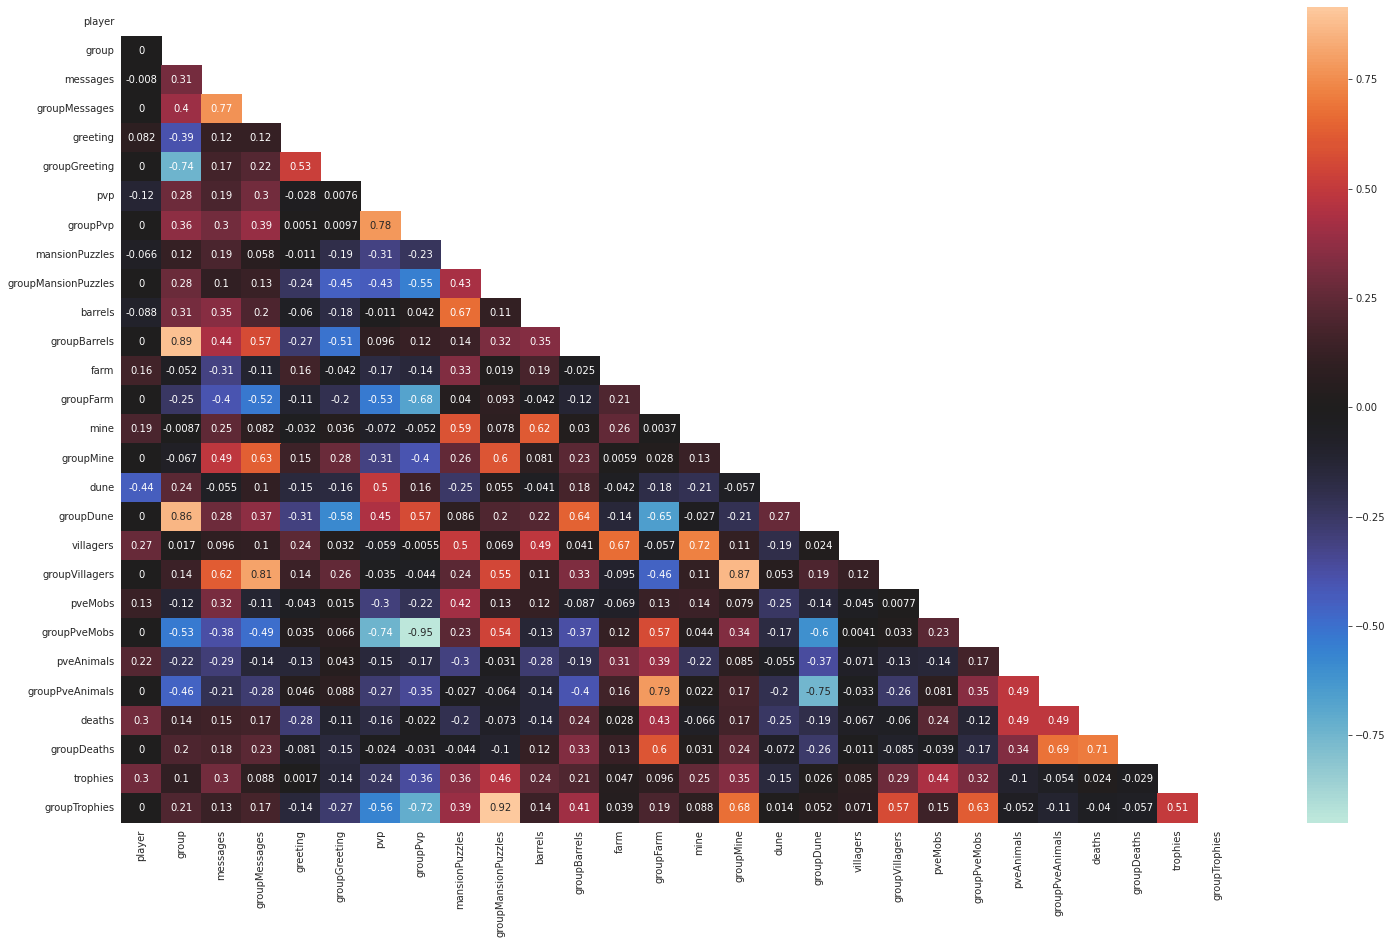

In [17]:
corrmatx = combdf.corr()
mask = np.zeros_like(corrmatx)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(25,15))
    ax = sns.heatmap(corrmatx, mask=mask, center=0, annot=True)